In [1]:
from modules.tweet_data import read_raw_data

import pandas as pd
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import matplotlib.pyplot as plt

In [2]:
classi = pd.read_csv('data/handle_class.csv')

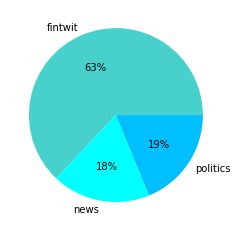

In [3]:
plt.pie(classi.groupby('class').count()['handle'], 
        labels=classi.groupby('class').count()['handle'].index,
        autopct='%1.0f%%', colors =['mediumturquoise', 'cyan', 'deepskyblue']);

In [7]:
plt.bar(classi.groupby('class').count())

TypeError: bar() missing 1 required positional argument: 'height'

In [2]:
tweet_df = read_raw_data()

Reading data


In [3]:
tweet_df.tail()

,tweet_id,handle,tweet
timestamp,,,
2020-07-11 00:32:55,1281687871406186497,RANsquawk,Cheers good sir!!! you too mate :)
2020-07-11 00:37:10,1281688941389905921,lindayueh,"Prime Minister, who posed in a face covering f..."
2020-07-11 00:52:55,1281692904071876611,bopinion,"Today, roughly 20% of all U.S.-listed stocks a..."
2020-07-11 01:22:53,1281700446281838605,bopinion,We'll have to re-think some of our notions abo...
2020-07-11 01:53:32,1281708159606894598,bopinion,Something important is afoot. Chinese stock ...


In [4]:
tweet_df = tweet_df[tweet_df.index < '06-01-2020']

In [4]:
from spacy.tokenizer import _get_regex_pattern
from spacy.tokens import Token

nlp = spacy.load('en_core_web_sm')

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add your patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

 #set a custom extension to match if token is a hashtag
piclink_getter = lambda token: bool(re.match("pic.twitter.com\S+", token.text))
Token.set_extension('is_piclink', getter=piclink_getter,force=True)
hashtag_getter = lambda token: bool(re.match("#\w+", token.text))
Token.set_extension('is_hashtag', getter=hashtag_getter,force=True)


def twitter_tokenizer(d, 
                      model=nlp, 
                      urls=True,
                      stop_words=True, 
                      lowercase=True, 
                      alpha_only=True, 
                      hashtags=False,
                      lemma=False):
    """Full tokenizer with flags for processing steps
    urls: If True, remove URLs
    stop_words: If True, removes stop words
    lowercase: If True, lowercases all tokens
    alpha_only: If True, removes all non-alpha characters
    lemma: If True, lemmatizes words
    
    The tokenizer also removes all URLS
    """
    parsed = model(d)
    # token collector
    tokens = []
    for t in parsed:
        # remove URLs
        if (t.like_url or t._.is_piclink)&(urls):
            continue
        # only include stop words if stop words==True
        if (t.is_stop)&(stop_words):
            continue
        # only include non-alpha is alpha_only==False
        if (not t.is_alpha)&(alpha_only):
            if hashtags:
                continue
            else:
                if not t._.is_hashtag:
                    continue           
        if lemma:
            t = t.lemma_
        else:
            t = t.text
        if lowercase:
            t.lower()
        tokens.append(t)
    return(tokens)

In [110]:
cv = CountVectorizer(tokenizer=twitter_tokenizer)
count_vecs = cv.fit_transform(single_day.tweet)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_vecs = lda.fit_transform(count_vecs)

In [113]:
tfidf = TfidfVectorizer(tokenizer=twitter_tokenizer)
tfidf_vecs = tfidf.fit_transform(single_day.tweet)

nmf = NMF(n_components=5, random_state=42)
nmf_vecs = nmf.fit_transform(tfidf_vecs)

# EDA

2012-11-07 obama election  
2015-07-08 The New York Stock Exchange stops trading for nearly four hours due to a technical error  
2015-09-17 Fed meeting  
2015-12-16 US Federal Reserve raises interest rates by 0.25% for the first time since 2006  
2016-03-16 Fed leaves rates unchanged  
2016-06-24 Brexit  
2016-10-20 Debate  
2016-11-09  Trump election  
2017-06-09 Conservatives lose majority in UK  
2018-11-07 Midterms  

In [6]:
tweets_per_day = tweet_df.tweet.groupby(by=tweet_df.index.date).count()

Text(0.5, 1.0, 'Tweets per day')

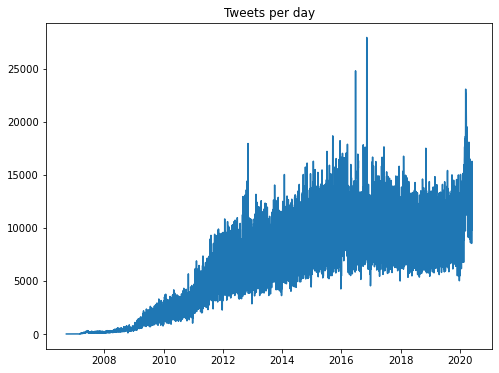

In [7]:
plt.subplots(figsize=(8,6))
plt.plot(tweets_per_day)
plt.title("Tweets per day")

In [8]:
tweets_per_day[tweets_per_day > 17000]

2012-11-07    17939
2015-07-08    17197
2015-09-17    18660
2015-12-16    18206
2016-01-15    17015
2016-03-02    17057
2016-03-16    17869
2016-06-24    24785
2016-09-27    17819
2016-10-20    17602
2016-11-09    27929
2017-06-09    17623
2018-11-07    17494
2020-02-28    17639
2020-03-03    17594
2020-03-04    18346
2020-03-06    17348
2020-03-09    18626
2020-03-11    19537
2020-03-12    23061
2020-03-13    20744
2020-03-16    22648
2020-03-17    20985
2020-03-18    21861
2020-03-19    20812
2020-03-20    20098
2020-03-23    18766
2020-03-24    19513
2020-03-25    19081
2020-03-26    19490
2020-03-27    18095
2020-04-01    17019
2020-04-02    17744
2020-04-03    17113
2020-04-08    17215
2020-04-16    17025
2020-04-21    18062
Name: tweet, dtype: int64

In [9]:
users_per_day = tweet_df.handle.groupby(by=tweet_df.index.date).nunique()

Text(0.5, 1.0, 'Users per day')

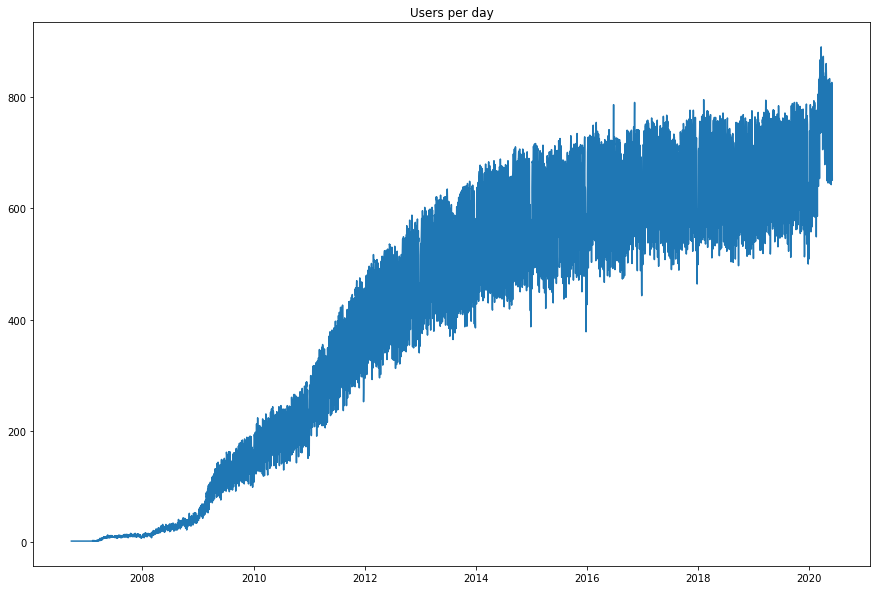

In [10]:
plt.subplots(figsize=(15,10))
plt.plot(users_per_day)
plt.title('Users per day')

In [11]:
active_twitters = tweet_df.handle.groupby(by=tweet_df.handle).count()

<BarContainer object of 1146 artists>

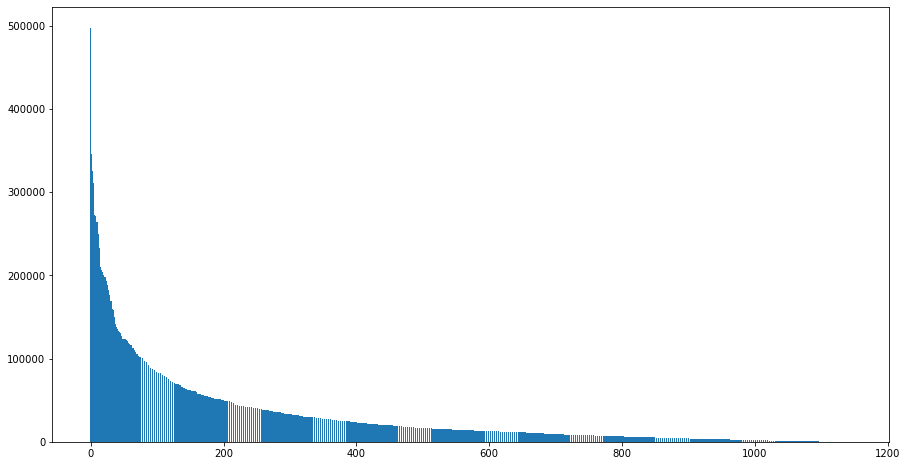

In [20]:
plt.subplots(figsize=(15,8))
plt.bar(range(len(active_twitters)),active_twitters.sort_values(ascending=False))

In [72]:
active_twitters['realDonaldTrump']

43002

In [18]:
single_day = tweet_df['2016-11-09']
#single_day = tweet_df['2018-09-09']

In [19]:
single_day

,tweet_id,handle,tweet
timestamp,,,
2018-09-09 00:00:00,1038517328097423360,FoxBusiness,How a change in Washington attitude has moved ...
2018-09-09 00:00:00,1038517330542616576,RT_America,The Trump Admin. Muzzles Nuclear Weapons Safet...
2018-09-09 00:00:01,1038517333961134080,haaretzcom,Ring in the Jewish New Year with these Iranian...
2018-09-09 00:00:06,1038517354316144645,AJENews,Mexican President-elect Andres Manuel Lopez Ob...
2018-09-09 00:00:06,1038517354408419328,nytimes,"Nearly 23,000 readers submitted questions abou..."
...,...,...,...
2018-09-09 23:58:31,1038879343559274498,BenjaminNorton,Profit-seeking arsonist gets patent for techno...
2018-09-09 23:58:49,1038879417165074432,EuropeElects,Sweden: Our projection says MP will surpass th...
2018-09-09 23:58:56,1038879447691055104,LA_Banker,"I don’t say this lightly, but it really is."


In [33]:
cv = CountVectorizer(tokenizer=twitter_tokenizer)
count_vecs = cv.fit_transform(single_day.tweet)

In [34]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_vecs = lda.fit_transform(count_vecs)

In [35]:
def display_components(model, word_features, top_display=5):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print(" ".join(top_words))

In [36]:
display_components(lda, cv.get_feature_names(),top_display=20)

Topic 0:
sweden election #100yearsago sep new polls #val2018 exit party china #valet2018 poll france look swedish #swedenelection today times northern people
Topic 1:
like china trump amazon president new week know money people good today need market bad trade says world car great
Topic 2:
trump new people think time president years right thanks like says sure work yes house need good party said want
Topic 3:
north military korea trump like parade says people kavanaugh anniversary think russian new point years sunday market know missiles government
Topic 4:
serena good osaka people open like right williams new got year naomi game time great man final way going lot


In [122]:
sub = [lda, cv, nmf, tfidf]

In [127]:
import pickle
pickle.dump(sub, open( "save.p", "wb" ))

In [8]:
import pickle
a = pickle.load(open( "save.p", "rb" ))

In [11]:
display_components(a[2], a[3].get_feature_names(), top_display=20)

[LatentDirichletAllocation(n_components=5, random_state=42),
 CountVectorizer(tokenizer=<function twitter_tokenizer at 0x7ffc201e0170>),
 NMF(n_components=5, random_state=42),
 TfidfVectorizer(tokenizer=<function twitter_tokenizer at 0x7ffc201e0170>)]